# Policy Gradient Gridworld Experiments

In the following notebook we present implementations for *vanilla* and *natural policy gradient* algorithms assuming either *first order orcale access* to the gradients or *stochastic estimation with Monte-Carlo sampling*. 

Policy gradient algorithms generally work by iterating the following assignment operation:
$$
\theta_{t+1} \rightarrow \theta_{t}  + \eta g_t,
$$
where:
|  | Vanilla PG | Natural PG |
|---|---|---|
| Oracle | $g_t = \nabla_\theta J(\theta_t) $ | $g_t = \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) $ |
| Monte-Carlo | $g_t \approx \nabla_\theta J(\theta_t) $ | $g_t \approx \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) $ |

In this work we will always assume (at least for now) that the policy is parametrized by a direct-softmax:
$$
\pi(s,a) = \frac{\exp \theta(s,a)}{\sum_{a'\in A} \exp \theta(s,a')},
$$
the quantity that we optimize on (*the return*) is given by:
$$
J(\theta) = (1-\gamma) \mathbb{E}_{s \sim \theta}\Big[ \sum_{t=0}^{+\infty} \gamma^t r(s_t,a_t) \Big].
$$
For now we only care about the unregularized case.
- [ ] TODO : introduce regularization 

#### Includes and initialization

In [232]:
""" Includes """
import numpy as np
import numpy.random as rd
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import matplotlib.pyplot as plt
from env.mdp import MarkovDecisionProcess,Sampler
from env.gridworld import Gridworld, gridplot
from env.complete import Complete
from algs.projs import euclidean_l1ball, euclidean_simplex, euclidian_pos_orthant
from algs.lps import unregCMDPLP
from typing import Tuple
from itertools import accumulate
from einops import rearrange, repeat
Point = Tuple[int,int]
Goal = Tuple[Point,float]

""" Useful helper functions """
def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 

#### Instanciating a Gridworld environment

In [229]:
goals = [((7,4),100)]
gridMDP = Gridworld(8,5,0.1,0.9,goals=goals,obstacles=[]) 

#### Instanciating a policy parametrization

In [198]:
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
def softmax_pi(theta):
    return jnp.exp(theta)/jnp.repeat(jnp.expand_dims(jnp.sum(jnp.exp(theta),1),1),4,1)
pi_theta = softmax_pi(theta)

#### Computing the quantity $\nabla J(\theta)$

In [234]:
def closed_loop_kernel(mdp,pi):
    return jnp.einsum('sap,sa->sp',mdp.P_sa,pi) # closed loop transition kernel
def state_occ_measure(mdp,P_pi):
    return (1-mdp.gamma)*(jnp.linalg.inv((jnp.eye(mdp.n)-mdp.gamma*P_pi)).transpose()@mdp.init_distrib)
def occ_measure(mdp,pi):
    mu_s = state_occ_measure(mdp,closed_loop_kernel(mdp,pi))
    return pi * repeat(mu_s, 's -> s new_axis', new_axis=mdp.m)
def J_unregularized(mdp,theta):
    return jnp.dot(flatten(mdp.R),flatten(occ_measure(gridMDP,softmax_pi(theta))))
policyGrad = jax.grad(lambda p : J_unregularized(gridMDP,softmax_pi(p)))

#### A generic policy gradient implementation

In [279]:
def PolicyGradient(_g):
    def logger(theta):
        return {
            'pi': softmax_pi(theta),
            'J': J_unregularized(gridMDP, theta)
        }
        
    nb_steps = 40
    theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
    eta = 20 # learning rate
    log = [logger(theta)]
    for step in range(nb_steps):
        theta += eta * _g(theta)
        log += [logger(theta)]
    return log, theta
log, theta = PolicyGradient(policyGrad)

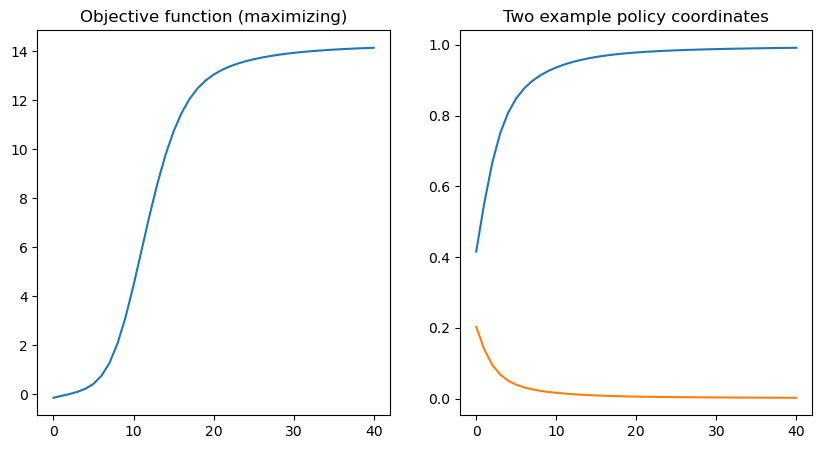

In [280]:
pis=jnp.stack([e['pi'] for e in log])
js=jnp.stack([e['J'] for e in log])
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(js)
ax[0].set_title('Objective function (maximizing)')
ax[1].plot(pis[:,0,:2])
ax[1].set_title('Two example policy coordinates')
plt.show()